In [15]:
import pandas as pd
import os
import glob
import snowflake.connector


Read all files

In [16]:

# Define the path to your data
data_path = "./"

# Load all .csv.gz files in the 'hosp' folder
hosp_files = glob.glob(os.path.join(data_path, 'hosp/*.csv.gz'))

# Create a dictionary of DataFrames
hosp_dfs = {os.path.basename(f): pd.read_csv(f) for f in hosp_files}
# # Now you can access each DataFrame by the filename, example: print(hosp_dfs['admissions.csv.gz'].head())


# Load all .csv.gz files in the 'hosp' folder
icu_files = glob.glob(os.path.join(data_path, 'icu/*.csv.gz'))

# Create a dictionary of DataFrames
icu_dfs = {os.path.basename(f): pd.read_csv(f) for f in icu_files}
# # Now you can access each DataFrame by the filename, example: print(icu_dfs['icustays.csv.gz'].head())

/var/folders/ng/kxgs87g91gbb9s1st4h8n99m0000gq/T/ipykernel_15262/4262252691.py:8: DtypeWarning: Columns (4,6,7,8,9,10,11,12,13,15,16,17,18,21,23,24,25,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  hosp_dfs = {os.path.basename(f): pd.read_csv(f) for f in hosp_files}


Example Analysis - ICU stay analysis

/var/folders/ng/kxgs87g91gbb9s1st4h8n99m0000gq/T/ipykernel_15262/3324537896.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  readmissions_df = icustays_df.groupby('subject_id').apply(lambda x: x.sort_values('intime')).reset_index(drop=True)


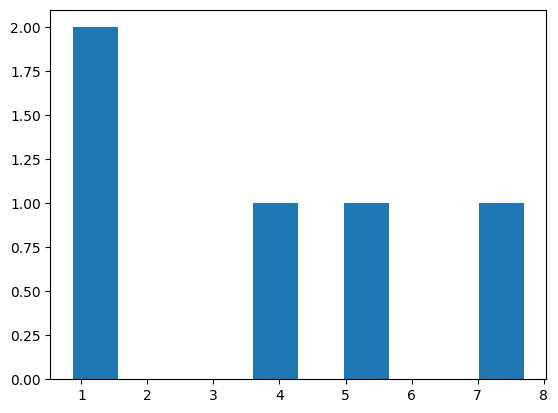

In [17]:
# Load the icustays table
icustays_df = icu_dfs['icustays.csv.gz'].head()
# print(icustays_df)
# Calculate the length of stay for each ICU admission
icustays_df = icustays_df.assign(
    length_of_stay=(pd.to_datetime(icustays_df['outtime']) - pd.to_datetime(icustays_df['intime'])).dt.total_seconds() / (60 * 60 * 24)
)
length_of_stay_distribution = icustays_df['length_of_stay'].hist(grid=False)

icustays_df = icustays_df.assign(outtime = pd.to_datetime(icustays_df['outtime']))
icustays_df = icustays_df.assign(intime = pd.to_datetime(icustays_df['intime']))

# Check readmission within 30 days
readmissions_df = icustays_df.groupby('subject_id').apply(lambda x: x.sort_values('intime')).reset_index(drop=True)
readmissions_df.loc[:,'readmission'] = readmissions_df.groupby('subject_id')['intime'].diff().dt.total_seconds() / (60 * 60 * 24)
readmission_rate = (readmissions_df['readmission'] < 30).mean()

**Proposed Solution**

MIMIC-IV Data pre-processing

In [18]:

def generate_summary_from_csv(patient_id, df, key_column='subject_id'):
    """
    Generates a summary for a given patient based on the information available in a single DataFrame.
    
    Parameters:
    - patient_id: The ID of the patient.
    - df: The DataFrame containing data for the patient.
    - key_column: The column to use as a key for filtering the DataFrame (default is 'subject_id').
    
    Returns:
    - A summary string.
    """
    # Check if the key_column exists in the DataFrame
    if key_column not in df.columns:
        return None
    
    # Filter the DataFrame for the specific patient
    patient_data = df[df[key_column] == patient_id]
    
    if patient_data.empty:
        return None
    
    row = patient_data.iloc[0]  # Take the first row for simplicity
    
    summary_parts = []
    for column_name, value in row.items():
        if pd.notna(value):
            summary_parts.append(f"{column_name}: {value}")
    
    return ". ".join(summary_parts) + "."

def generate_aggregated_summary(patient_id, hosp_dfs, icu_dfs):
    summary_parts = []
    
    # Generate summaries from hospital DataFrames
    for file_name, df in hosp_dfs.items():
        key_column = 'subject_id' if 'subject_id' in df.columns else 'hadm_id'
        summary = generate_summary_from_csv(patient_id, df, key_column=key_column)
        if summary:
            summary_parts.append(summary)
    
    # Generate summaries from ICU DataFrames
    for file_name, df in icu_dfs.items():
        key_column = 'subject_id' if 'subject_id' in df.columns else 'stay_id'
        summary = generate_summary_from_csv(patient_id, df, key_column=key_column)
        if summary:
            summary_parts.append(summary)
    
    return " ".join(summary_parts)

# Get a list of all unique patient IDs (from any DataFrame, such as patients.csv.gz)
patient_ids = hosp_dfs['patients.csv.gz']['subject_id'].unique()

# Dictionary to store the summaries
all_patient_summaries = {}

# Generate summaries for each patient
for patient_id in patient_ids:
    summary = generate_aggregated_summary(patient_id, hosp_dfs, icu_dfs)
    all_patient_summaries[patient_id] = summary
    # break

# Convert to DataFrame for easy handling
summary_df = pd.DataFrame(list(all_patient_summaries.items()), columns=['subject_id', 'patient_summary'])
print(summary_df['subject_id'].values[0], ' : ', summary_df['patient_summary'].values[0])
summary_df.to_csv('to_sf.csv')


10014729  :  poe_id: 10014729-590. poe_seq: 590. subject_id: 10014729. hadm_id: 23300884. ordertime: 2125-03-26 09:02:16. order_type: Medications. transaction_type: New. order_provider_id: P00AEX. order_status: Inactive. poe_id: 10014729-518. poe_seq: 518. subject_id: 10014729. field_name: Admit to. field_value: Surgery. subject_id: 10014729. gender: F. anchor_age: 21. anchor_year: 2125. anchor_year_group: 2011 - 2013. subject_id: 10014729. hadm_id: 23300884. seq_num: 3. icd_code: 99832. icd_version: 9. subject_id: 10014729. hadm_id: 23300884. pharmacy_id: 8661097. poe_id: 10014729-356. poe_seq: 356.0. order_provider_id: P98O2Z. starttime: 2125-03-19 20:00:00. stoptime: 2125-03-20 18:00:00. drug_type: MAIN. drug: Insulin. formulary_drug_cd: INRHI. gsn: 001723. ndc: 2821501.0. prod_strength: 100 Units / mL - 10 mL Vial. dose_val_rx: 0. dose_unit_rx: UNIT. form_val_disp: 0. form_unit_disp: mL. route: SC. subject_id: 10014729. hadm_id: 28889419. drg_type: HCFA. drg_code: 908. description:

**Snowflake Connection** 

I have credentials listed here in case you want to go into this test snowflake instance and explore it.

In [19]:
#!/usr/bin/env python

conn = snowflake.connector.connect(
    account = "WLISCTT.XLB22554",
    user = "puneetjain",
    password = "tBowz$M136o*YG1d",
    role = "ACCOUNTADMIN",
    warehouse = "COMPUTE_WH",
    database="PATIENT_TEXTS",
    schema="PUBLIC",
    region="us-west-2",
    login_timeout=60,  # Increase login timeout (in seconds)
    network_timeout=60 
    )

cur = conn.cursor()

# I have already put the above summary on snowflake, so just going to query it
cur.execute("SELECT * FROM PATIENT_TEXTS.PUBLIC.PATIENTSUMMARY LIMIT 1")

row = cur.fetchone()
print(row)

cur.close()
conn.close()


OperationalError: 250001: Could not connect to Snowflake backend after 1 attempt(s).Aborting

In [20]:
#!/usr/bin/env python
import snowflake.connector
import pandas as pd
from snowflake.connector.pandas_tools import write_pandas

ctx = snowflake.connector.connect(
    user='puneetjain',
    password='tBowz$M136o*YG1d',
    account='XLB22554',
    region='us-west-2',
    warehouse='COMPUTE_WH',
  	database='PATIENT_TEXTS',
    role = "ACCOUNTADMIN",
 	schema='PUBLIC'
    )
cs = ctx.cursor()
# try:
	# daf = {'BRAND': ['Apple','Samsung','Apple'],
        # 'MODEL': ['iPhone12','Note 10','iPhone11'],
        # 'SPACE_GB': [128,256,64],
        # 'COLOR': ['Black','Mirror','Red']
        # }
	# df = pd.DataFrame(daf, columns = ['BRAND', 'MODEL','SPACE_GB','COLOR'])
# cs = ctx.cursor()
cs.execute("SELECT * FROM PATIENT_TEXTS.PUBLIC.PATIENTSUMMARY LIMIT 1")
cs.close()
	# success, nchunks, nrows, _ = write_pandas(ctx, df, 'DEMO')
# finally:
    # cs.close()